In [2]:
import random
import numpy as np
import pandas as pd
import json

class CollectProbabilities():

    """
    This class finds the following probabilities:
    - Sex: a dictionary with the probability of Male and Female
    - Age: a dictionary with the probability of a person being a certain age [0-85]
    - Fertility: a dictionary with the probability of a female becoming pregnant by age [15-45]

    All the probabilities calculated are based on csv files downloaded from the CSO website
    """

    def __init__(self)-> None:
        # Read CSO data
        self.census_data = pd.read_csv("../../data/CSO_census_2016.csv")[["Age Group","Sex","VALUE"]]
        self.birth_data = pd.read_csv("../../data/CSO_birthRate_2020.csv")[["Age Group of Mother","VALUE"]].rename(
            columns={"Age Group of Mother":"Age Group"})
        # Read HSPC data
        self.death_data = pd.read_csv("../../data/HSPC_covidDeath_2020_2023.csv")[["Age Group","VALUE"]]
        
        self.total_population = self.census_data["VALUE"].sum()

        # Calculate the probability dictionary
        self.find_sex_probability()
        self.find_age_probability()
        self.find_fertility_rate()
        self.find_mortality_rate()

        # Save the dictionaries as a single JSON file
        self.save_dictionaries()

    def find_sex_probability(self) -> None:
        # Finds the probability of a person being female or male (rounded to 4 decimal places)
        # Sex Count
        self.sex_probability = (self.census_data.groupby("Sex").sum()[["VALUE"]]/self.total_population).to_dict()["VALUE"]
        # Sex Probability
        self.sex_probability["Female"] =  np.round(self.sex_probability["Female"],4)
        self.sex_probability["Male"] =  np.round(1 - self.sex_probability["Female"],4)

    def find_age_dict(self, dataframe:pd.DataFrame) -> dict:
        # This function takes in a dataframe and returns a dictionary with the age as the key and count as the value.
        age_dict = {}
        # Group by age
        for age_group, value in zip(dataframe.groupby("Age Group").sum()[["VALUE"]].index, dataframe.groupby("Age Group").sum()[["VALUE"]].values):
            # CSO stores the data in age groups e.g. 10 - 14 years
            years = age_group.split(" - ")
            if len(years) > 1: 
                # example values: start_age, end_age = 10, 14
                start_age, end_age = int(years[0]), int(years[1].split(" ")[0])
                age_gap = (end_age + 1) - start_age
                # Uniform distribution for ages in the age range
                for age in range(start_age, end_age + 1):
                    age_dict[age] = value[0]/age_gap
            else: # Some age groups are in a different format e.g. 45 years or older
                age = int(years[0].split(" ")[0])
                # example value: assigning the full count of 45 years or older to the 45
                age_dict[age] = value[0]
        return age_dict

    def find_age_probability(self) -> None:
        """
        This function calculates the probability of a person being a certain age [0-85].
        It does this by getting the number of people for each possible age and dividing by the total population.
        """
        self.age_probability = {}
        # The count for each age.
        self.population_by_age_dict = self.find_age_dict(self.census_data)
        for age, value in self.population_by_age_dict.items():
            self.age_probability[age] = np.round((value / self.total_population),4)

    def find_fertility_rate(self)-> None:
        """
        This function calculates the fertility probability of a female at different ages [15-45].
        It does this by getting the number of birth for each possible age and dividing by the number of females that age.
        """
        # The count of females at different ages.
        age_dict = self.find_age_dict(self.census_data[self.census_data["Sex"] == "Female"])
        # The 2020 birth counts per age.
        births_per_age = self.find_age_dict(self.birth_data)
        self.fertility_rate = {}
        for age in age_dict.keys():
            # The fertility_rate per age, returns 0 if their wasn't any births for the age
            self.fertility_rate[age] = np.round((births_per_age.get(age, 0) / age_dict.get(age)),4)

    def find_mortality_rate(self) -> None:
        """
        This function calculates the mortality probability of a person at different ages [0-85].
        It does this by getting the number of death people for each possible age and dividing by the total population of that age.
        """
        self.mortality_rate = {}
        # The count for each age.
        age_dict = self.find_age_dict(self.death_data)
        for age, value in self.population_by_age_dict.items():
            self.mortality_rate[age] = np.round((age_dict.get(age, 0) / value),10)

    def save_dictionaries(self):
        # Create a super-dictionary, the previous dictionaries as sub-dictionaries
        complete_probabilities = {"sex_probability":self.sex_probability,
                                "age_probability":self.age_probability,
                                "fertility_rate":self.fertility_rate,
                                "mortality_rate":self.mortality_rate,
                                }
        # Save dictionary to a json file
        output_file = open('../../data/person_probabilities.json', 'w', encoding='utf-8')
        json.dump(complete_probabilities, output_file, indent=4)
        output_file.close()

In [15]:
pd.read_csv("../../data/CSO_vaccinationRate_2021_2023.csv")

,Statistic Label,Month,Local Electoral Area,Age Group,UNIT,VALUE
0,Primary Course Completed,2021 January,"Borris-In-Ossory-Mountmellick, Laois",5 - 11 years,%,NaN
1,Primary Course Completed,2021 January,"Borris-In-Ossory-Mountmellick, Laois",12 years and over,%,2.8
2,Primary Course Completed,2021 January,"Portlaoise, Laois",5 - 11 years,%,NaN
3,Primary Course Completed,2021 January,"Portlaoise, Laois",12 years and over,%,2.1
4,Primary Course Completed,2021 January,"Graiguecullen -Portarlington, Laois",5 - 11 years,%,NaN
...,...,...,...,...,...,...
17259,Booster 1,2023 February,"Kilkenny, Kilkenny",12 years and over,%,58.9
17260,Booster 1,2023 February,"Piltown, Kilkenny",5 - 11 years,%,0.0
17261,Booster 1,2023 February,"Piltown, Kilkenny",12 years and over,%,58.9
17262,Booster 1,2023 February,"Callan-Thomastown, Kilkenny",5 - 11 years,%,0.0


In [152]:
def convert_to_datetime(x):
    return pd.to_datetime(x)

def find_vaccination_stats():
    # Read vaccine data, convert nulls to 0 and divide by 100 to get it as a fraction.
    vaccination_rate = pd.read_csv("../../data/CSO_vaccinationRate_2021_2023.csv").groupby(["Statistic Label", "Month", "Age Group"])[["VALUE"]].mean().fillna(0) / 100

    # Reformat index to convert month to datetime format
    vaccination_rate.index = vaccination_rate.reindex(
    [(vaccine_type, convert_to_datetime(month), age_group) for vaccine_type, month, age_group in zip(
    vaccination_rate.index.get_level_values(0),
    vaccination_rate.index.get_level_values(1),
    vaccination_rate.index.get_level_values(2))]).index

    separated_vaccine = pd.DataFrame(index=pd.date_range(start="2020-01-01", end="2023-02-01", freq="MS"))

    short_hand_dict = {"Primary Course Completed":"V1",
                "Booster 1":"V2",
                "5 - 11 years":"11-",
                "12 years and over":"12+"}
            
    for vaccine_type in ["Primary Course Completed", "Booster 1"]:
        for age_group in ["5 - 11 years", "12 years and over"]:
            separated_vaccine = separated_vaccine.join(
                vaccination_rate.loc[vaccine_type,:, age_group].sort_index().rename(
                columns={"VALUE":f"{short_hand_dict[vaccine_type]}_{short_hand_dict[age_group]}"}))
    return separated_vaccine.fillna(0)
    

In [153]:
vaccination_rate = find_vaccination_stats()
vaccination_rate

,V1_11-,V1_12+,V2_11-,V2_12+
2020-01-01,0.000000,0.000000,0.0,0.000000
2020-02-01,0.000000,0.000000,0.0,0.000000
2020-03-01,0.000000,0.000000,0.0,0.000000
2020-04-01,0.000000,0.000000,0.0,0.000000
2020-05-01,0.000000,0.000000,0.0,0.000000
2020-06-01,0.000000,0.000000,0.0,0.000000
2020-07-01,0.000000,0.000000,0.0,0.000000
2020-08-01,0.000000,0.000000,0.0,0.000000
2020-09-01,0.000000,0.000000,0.0,0.000000
2020-10-01,0.000000,0.000000,0.0,0.000000


In [146]:
short_hand_dict = {"Primary Course Completed":"V1",
                "Booster 1":"V2",
                "5 - 11 years":"11-",
                "12 years and over":"12+"}
            
for vaccine_type in ["Primary Course Completed", "Booster 1"]:
    for age_group in ["5 - 11 years", "12 years and over"]:
        vaccination_rate.loc[vaccine_type,:, age_group].sort_index().rename(
            columns={"VALUE":f"{short_hand_dict[vaccine_type]}_{short_hand_dict[age_group]}"})

<Axes: xlabel='Month'>

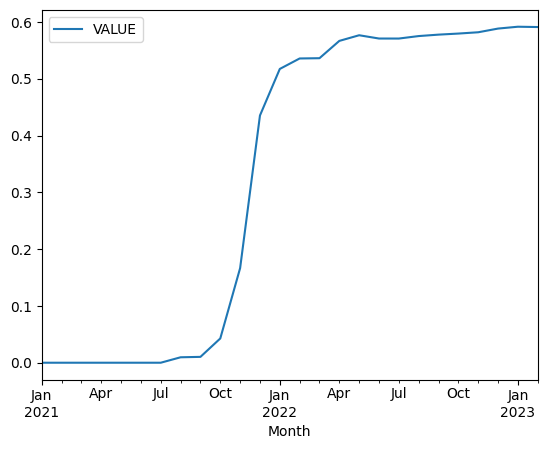

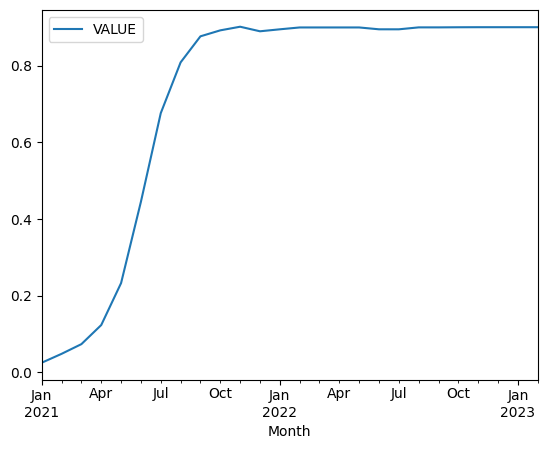

In [137]:
vaccination_rate.loc["Booster 1",:, "12 years and over"].sort_index().plot()
vaccination_rate.loc["Primary Course Completed",:, "12 years and over"].sort_index().plot()

In [34]:
vaccination_rate.loc["Booster 1", :, "12 years and over"]

,VALUE
Month,
2021 April,0.000000
2021 August,0.958434
2021 December,43.528916
2021 February,0.000000
2021 January,0.000000
2021 July,0.000000
2021 June,0.000000
2021 March,0.000000
2021 May,0.000000


In [4]:
CP = CollectProbabilities()

In [5]:
CP.fertility_rate[20]

0.0317

In [6]:
def return_random_choice(probability_dict):
    """
    Takes a dictionary with a person's characteristics as the keys and the probability as the values.
    Returns a random choice of the characteristics based on the probabilities.  
    """
    return random.choices(list(probability_dict.keys()), weights=list(probability_dict.values()), k=1)[0]

return_random_choice(CP.fertility_rate)

40

In [7]:
class Person():
    """
    This class set ups the initial values for agents in our system.
    """
    global PersonID
    PersonID = 1
    def __init__(self, sex_probability:dict, age_probability:dict, fertility_rate:dict, mortality_rate:dict) -> None:
        global PersonID
        self.id = PersonID
        # Assigns a random age and sex based on the Irish population census data
        self.age = return_random_choice(age_probability) 
        self.sex = return_random_choice(sex_probability)
        # Assigns the fertility_rate, mortality_rate based on the average for a person that age.
        self.fertility_rate = 0 if self.sex == "Male" else fertility_rate.get(self.age, 0)
        self.mortality_rate = mortality_rate.get(self.age, 0)

        # Covid Variables
        self.vaccinated = 0 # unvaccinated, vaccinated, 1 booster = 0, 1, 2
        self.infected = 0 # uninfected, is infected, was infected = 0, 1, 2

        # Other variables ? mobility?
        # self.mobility = could be a random int or a fixed variable
        
        PersonID += 1
    
    def __str__(self):
        return f"Person {self.id} is a {self.age} year old {self.sex}.\n\
They have the fertility_rate {self.fertility_rate} and the mortality_rate {self.mortality_rate}"

class NewBorn(Person):
    """
    NewBorn is a subclass of Person and inheritance from the Person class.
    The range of characteristics is more limited. 50/50 chance of being male/female
    100% chance of being 0 years old and having a fertility and mortality rate of 0. 
    """
    def __init__(self) -> None:
         super().__init__(sex_probability={"Female":0.5, "Male":0.5}, 
                          age_probability={0:1}, 
                          fertility_rate={0:0}, 
                          mortality_rate={0:0})

In [8]:
input_file = open("../../data/person_probabilities.json", "r")
population_characteristics = json.load(input_file)
input_file.close()

In [9]:
population_characteristics.keys()

dict_keys(['sex_probability', 'age_probability', 'fertility_rate', 'mortality_rate'])

In [11]:
population = {}
for i in range(1000):
    P = Person(**population_characteristics)
    population[P.id] = P
    

In [12]:
P = NewBorn()
print(P)

Person 1001 is a 0 year old Female.
They have the fertility_rate 0 and the mortality_rate 0


In [13]:
print(population[1])

Person 1 is a 73 year old Female.
They have the fertility_rate 0.0 and the mortality_rate 0.0043846135
